# A more complex problem

### Best Solution Selection

The results of the previous study suggest that for the simple problem we are considering, all the optimizations in which at every iteration the circuit is measured at least 64 times, provide a solution containing the optimal solution. 

In general, we may expect that for more complex problems, just a fraction of the optimizations fulfills this goal.
In that case, we would like to find a way to select a solution that with large probability contains the optimal solution.

For this, we can try building a more complex problem, so that solving it is not as trivial as in the previous case.

In [1]:
# To import the functions defined in the Functions.py module
from Functions import cost_function_C, VQE_circuit, cost_function_cobyla, time_vs_shots
from Functions import scatter_plot, best_candidate_finder, F_opt_finder, cv_a_r, save_object
from Functions import plot_comparison, random_graph_producer, brute_force_solver, PI
from Functions import load_files, analyze_results

In [2]:
# Other libraries
import numpy as np
import pandas as pd

[[ 0.  7.  0.  9.  3.  0.  5.  2.  0.  8.]
 [ 7.  0.  0.  7.  8.  0.  0.  8.  1.  0.]
 [ 0.  0.  0.  5.  0.  0.  3.  0.  0. 10.]
 [ 9.  7.  5.  0.  0.  0.  0.  0.  0.  5.]
 [ 3.  8.  0.  0.  0.  0.  0.  8.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  7.  0.]
 [ 5.  0.  3.  0.  0.  0.  0. 10.  2.  0.]
 [ 2.  8.  0.  0.  8.  0. 10.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  7.  2.  0.  0.  1.]
 [ 8.  0. 10.  5.  0.  0.  0.  1.  1.  0.]]


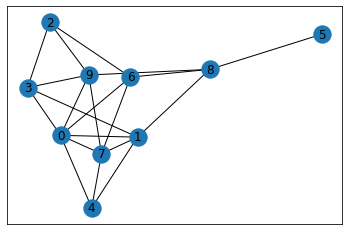

In [3]:
# Create random Max-Cut problem

# Number of vertices
n = 10

# Number of edges
E = 20

# Random seed
seed = 2000

W2 = random_graph_producer(n, E, seed, verbosity=True)


Best solution = [[1, 0, 1, 0, 0, 0, 0, 1, 1, 0], [0, 1, 0, 1, 1, 1, 1, 0, 0, 1]] cost = 88.0


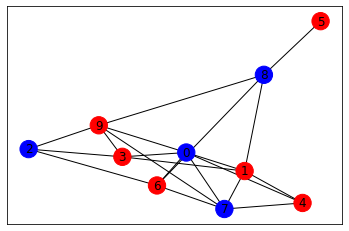

In [4]:
# Solve the Max-Cut problem using brute-force approach
# and save the solution
brute_solution, brute_cost = brute_force_solver(W2, verbosity=True)

### Optimization using mean value

In [5]:
# Variables declaration
WEIGHTS    = W2
N_QBITS    = n
DEPTH      = 2
SHOTS      = 64
BACKEND    = 'qasm_simulator'
FINAL_EVAL = 128
COST       = 'cost'

N_repetitions = 100
shots_list = [1, 2, 4, 8, 12, 16, 24, 32, 64, 96, 128]

In [ ]:
# A small scan, but we can get some results

for shot in shots_list:
    results_current = []
    output = 0
    file_name = "files/Scan_" + str(n) + "qbits_" + str(shot) + ".pkl"
    for rep in range(N_repetitions): 
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL,
                               COST) 
        
        if rep % 20 == 0:
            print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)

    save_object(results_current, file_name) 

In [6]:
# Load results
res_mean = load_files("files/10qbits_mean/Scan_10qbits", shots_list)
df_mean, df_plot_mean = analyze_results(res_mean, shots_list, W2, brute_solution, 'cost')

# Where to save figures
import os
folder_name = "figures/{0}qbits_mean/".format(n)

dir_command = "mkdir -p {0}".format(folder_name)
os.system(dir_command)

0

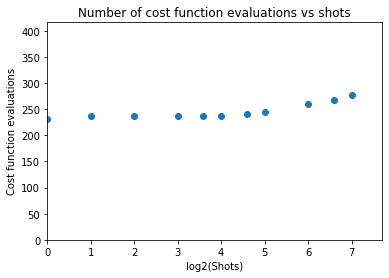

In [7]:
# Cost function evaluations vs log2(shots)
save_name = folder_name + "nfev_vs_log2shots"

scatter_plot(x       = np.log2(df_plot_mean.shots),
             y       = df_plot_mean.nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "log2(Shots)",
             ylabel  = "Cost function evaluations",
             save_as = save_name)

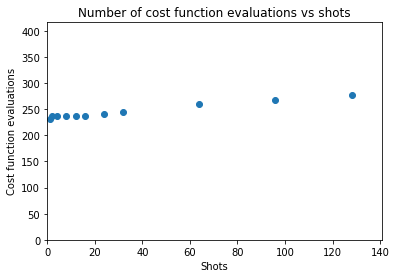

In [8]:
# Cost function evaluations vs shots
save_name = folder_name + "nfev_vs_shots"

scatter_plot(x       = df_plot_mean.shots,
             y       = df_plot_mean.nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Cost function evaluations",
             save_as = save_name)

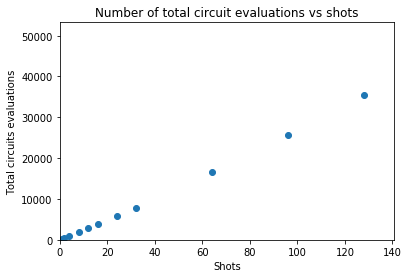

In [9]:
# Total circuit evaluations vs shots
save_name = folder_name + "nfev_x_shots_vs_shots"

scatter_plot(x       = df_plot_mean.shots,
             y       = df_plot_mean.nfevs*df_plot_mean.shots,
             title   = "Number of total circuit evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Total circuits evaluations",
             save_as = save_name)

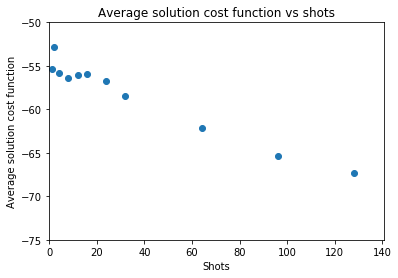

In [10]:
# Average solution cost function vs shots
save_name = folder_name + "cost_vs_shots"

scatter_plot(x       = df_plot_mean.shots,
             y       = df_plot_mean.cost,
             title   = "Average solution cost function vs shots",
             xlabel  = "Shots",
             ylabel  = "Average solution cost function",
             save_as = save_name,
             ylim    = (-75, -50))

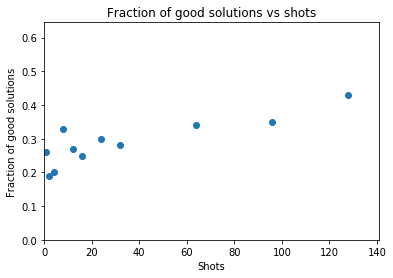

In [11]:
# Fraction of good solutions vs shots
save_name = folder_name + "frac_vs_shots"

scatter_plot(x       = df_plot_mean.shots,
             y       = df_plot_mean.frac,
             title   = "Fraction of good solutions vs shots",
             xlabel  = "Shots",
             ylabel  = "Fraction of good solutions",
             save_as = save_name)

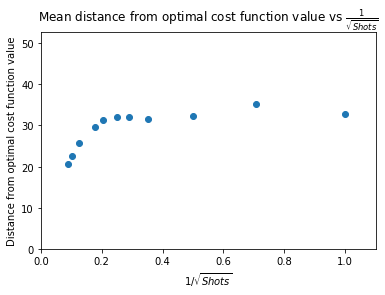

In [12]:
# Mean distance from optimal cost function value vs 1/sqrt(shots)
# (Brute cost is positive)
save_name = folder_name + "dist_vs_inv_shots"

scatter_plot(x       = 1 / np.sqrt(df_plot_mean.shots),
             y       = brute_cost + df_plot_mean.cost,
             title   = r"Mean distance from optimal cost function value vs $\frac{1}{\sqrt{Shots}}$",
             xlabel  = r"$1 / \sqrt{Shots}$",
             ylabel  = "Distance from optimal cost function value",
             save_as = save_name)

### Optimization using CVaR

#### CVaR with $\alpha = 0.5$

In [13]:
# Variables declaration
WEIGHTS    = W2
N_QBITS    = n
DEPTH      = 2
SHOTS      = 64
BACKEND    = 'qasm_simulator'
FINAL_EVAL = 128
COST       = 'cvar'
ALPHA      = 0.5

N_repetitions = 100
shots_list = [1, 2, 4, 8, 12, 16, 24, 32, 64, 96, 128]

In [ ]:
# A small scan, but we can get some results

for shot in shots_list:
    results_current = []
    output = 0
    file_name = "files/Scan_CVaR_" + str(n) + "qbits_" + str(shot) + ".pkl"
    for rep in range(N_repetitions): 
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL,
                               COST,
                               ALPHA) 
        
        if rep % 20 == 0:
            print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)

    save_object(results_current, file_name) 

In [14]:
# Load results                   
res_cvar_05  = load_files("files/10qbits_cvar_0.5/Scan_10qbits", shots_list)
df_CVaR_plot, df_CVaR_plot_mean = analyze_results(res_cvar_05, shots_list, W2, brute_solution, COST, ALPHA)

# Where to save figures
import os
folder_name = "figures/{0}qbits_CVaR_{1}/".format(n, ALPHA)

dir_command = "mkdir -p {0}".format(folder_name)
os.system(dir_command)

0

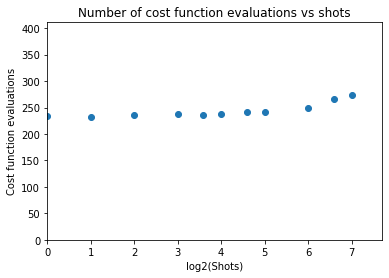

In [15]:
# Cost function evaluations vs log2(shots)
save_name = folder_name + "nfev_vs_log2shots"

scatter_plot(x       = np.log2(df_CVaR_plot_mean.shots),
             y       = df_CVaR_plot_mean.nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "log2(Shots)",
             ylabel  = "Cost function evaluations",
             save_as = save_name)

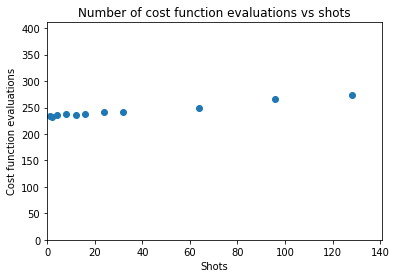

In [16]:
# Cost function evaluations vs shots
save_name = folder_name + "nfev_vs_shots"

scatter_plot(x       = df_CVaR_plot_mean.shots,
             y       = df_CVaR_plot_mean.nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Cost function evaluations",
             save_as = save_name)

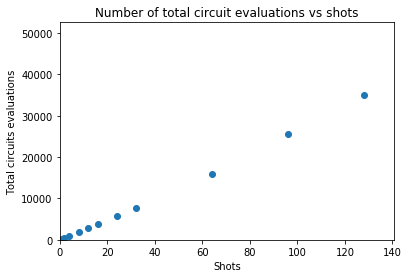

In [17]:
# Total circuit evaluations vs shots
save_name = folder_name + "nfev_x_shots_vs_shots"

scatter_plot(x       = df_CVaR_plot_mean.shots,
             y       = df_CVaR_plot_mean.nfevs*df_CVaR_plot_mean.shots,
             title   = "Number of total circuit evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Total circuits evaluations",
             save_as = save_name)

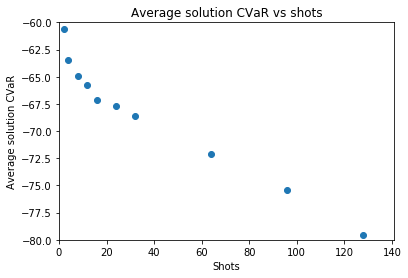

In [18]:
# Average solution cost function vs shots
save_name = folder_name + "cost_vs_shots"

scatter_plot(x       = df_CVaR_plot_mean.shots,
             y       = df_CVaR_plot_mean.cost,
             title   = "Average solution CVaR vs shots",
             xlabel  = "Shots",
             ylabel  = "Average solution CVaR",
             save_as = save_name,
             ylim    = (-80, -60))

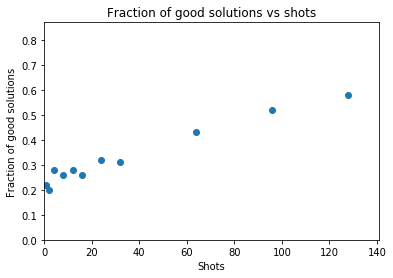

In [19]:
# Fraction of good solutions vs shots
save_name = folder_name + "frac_vs_shots"

scatter_plot(x       = df_CVaR_plot_mean.shots,
             y       = df_CVaR_plot_mean.frac,
             title   = "Fraction of good solutions vs shots",
             xlabel  = "Shots",
             ylabel  = "Fraction of good solutions",
             save_as = save_name)

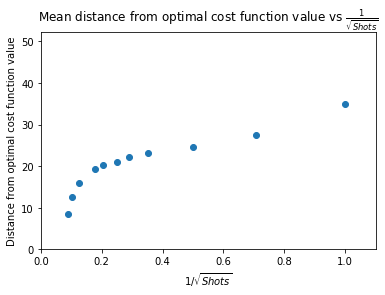

In [21]:
# Mean distance from optimal cost function value vs 1/sqrt(shots)
# (Brute cost is positive)
save_name = folder_name + "dist_vs_inv_shots"

scatter_plot(x       = 1 / np.sqrt(df_CVaR_plot_mean.shots),
             y       = brute_cost + df_CVaR_plot_mean.cost,
             title   = r"Mean distance from optimal cost function value vs $\frac{1}{\sqrt{Shots}}$",
             xlabel  = r"$1 / \sqrt{Shots}$",
             ylabel  = "Distance from optimal cost function value",
             save_as = save_name)

#### CVaR with $\alpha = 0.2$

In [22]:
# Variables declaration
WEIGHTS    = W2
N_QBITS    = n
DEPTH      = 2
SHOTS      = 8
BACKEND    = 'qasm_simulator'
FINAL_EVAL = 128
COST       = 'cvar'
ALPHA      = 0.2

N_repetitions = 100
shots_list = [1, 2, 4, 8, 12, 16, 24, 32, 64, 96, 128]

In [ ]:
# A small scan, but we can get some results

for shot in shots_list:
    results_current = []
    output = 0
    file_name = "files/Scan_CVaR_02_" + str(n) + "qbits_" + str(shot) + ".pkl"
    for rep in range(N_repetitions): 
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL,
                               COST,
                               ALPHA) 
        
        if rep % 20 == 0:
            print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)

    save_object(results_current, file_name) 

In [23]:
# Load results
res_cvar_02  = load_files("files/10qbits_cvar_0.2/Scan_10qbits", shots_list)
df_CVaR_02_plot, df_CVaR_02_plot_mean = analyze_results(res_cvar_02, shots_list, W2, brute_solution, COST, ALPHA)

# Where to save figures
import os
folder_name = "figures/{0}qbits_CVaR_{1}/".format(n, ALPHA)

dir_command = "mkdir -p {0}".format(folder_name)
os.system(dir_command)

0

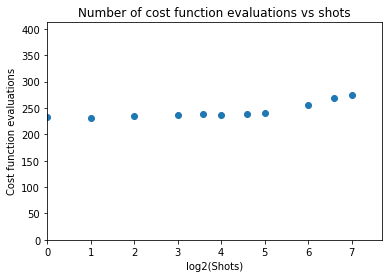

In [24]:
# Cost function evaluations vs log2(shots)
save_name = folder_name + "nfev_vs_log2shots"

scatter_plot(x       = np.log2(df_CVaR_02_plot_mean.shots),
             y       = df_CVaR_02_plot_mean.nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "log2(Shots)",
             ylabel  = "Cost function evaluations",
             save_as = save_name)

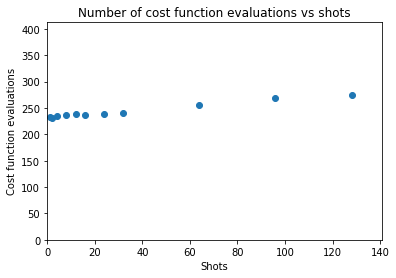

In [25]:
# Cost function evaluations vs shots
save_name = folder_name + "nfev_vs_shots"

scatter_plot(x       = df_CVaR_02_plot_mean.shots,
             y       = df_CVaR_02_plot_mean.nfevs,
             title   = "Number of cost function evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Cost function evaluations",
             save_as = save_name)

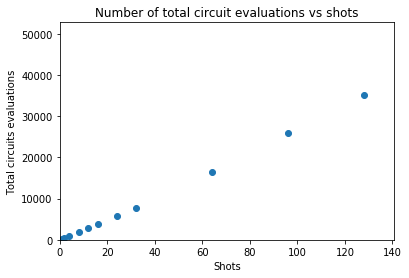

In [26]:
# Total circuit evaluations vs shots
save_name = folder_name + "nfev_x_shots_vs_shots"

scatter_plot(x       = df_CVaR_02_plot_mean.shots,
             y       = df_CVaR_02_plot_mean.nfevs*df_CVaR_02_plot_mean.shots,
             title   = "Number of total circuit evaluations vs shots",
             xlabel  = "Shots",
             ylabel  = "Total circuits evaluations",
             save_as = save_name)

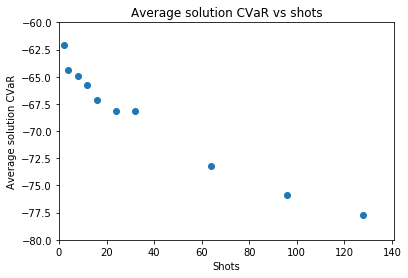

In [27]:
# Average solution cost function vs shots
save_name = folder_name + "cost_vs_shots"

scatter_plot(x       = df_CVaR_02_plot_mean.shots,
             y       = df_CVaR_02_plot_mean.cost,
             title   = "Average solution CVaR vs shots",
             xlabel  = "Shots",
             ylabel  = "Average solution CVaR",
             save_as = save_name,
             ylim    = (-80, -60))

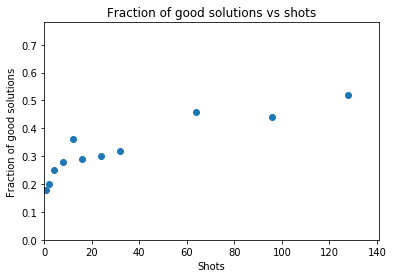

In [28]:
# Fraction of good solutions vs shots
save_name = folder_name + "frac_vs_shots"

scatter_plot(x       = df_CVaR_02_plot_mean.shots,
             y       = df_CVaR_02_plot_mean.frac,
             title   = "Fraction of good solutions vs shots",
             xlabel  = "Shots",
             ylabel  = "Fraction of good solutions",
             save_as = save_name)

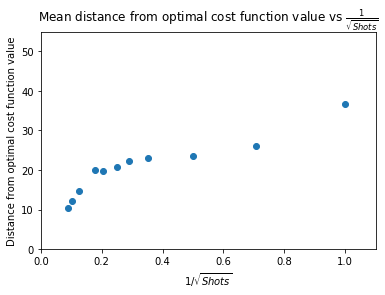

In [35]:
# Mean distance from optimal cost function value vs 1/sqrt(shots)
# (Brute cost is positive)
save_name = folder_name + "dist_vs_inv_shots"

scatter_plot(x       = 1 / np.sqrt(df_CVaR_02_plot_mean.shots),
             y       = brute_cost + df_CVaR_02_plot_mean.cost,
             title   = r"Mean distance from optimal cost function value vs $\frac{1}{\sqrt{Shots}}$",
             xlabel  = r"$1 / \sqrt{Shots}$",
             ylabel  = "Distance from optimal cost function value",
             save_as = save_name)

### Mean value vs CVaR

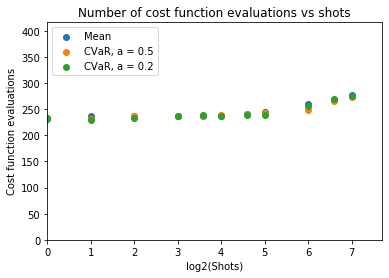

In [30]:
# Cost function evaluations vs log2(shots)
save_name = "figures/10qbits_comparison/nfev_vs_log2shots"

plot_comparison(x       = [np.log2(df_plot_mean.shots), np.log2(df_CVaR_plot_mean.shots), \
                           np.log2(df_CVaR_02_plot_mean.shots)],
                y       = [df_plot_mean.nfevs, df_CVaR_plot_mean.nfevs, df_CVaR_02_plot_mean.nfevs],
                legend  = ["Mean", "CVaR, a = 0.5", "CVaR, a = 0.2"],
                title   = "Number of cost function evaluations vs shots",
                xlabel  = "log2(Shots)",
                ylabel  = "Cost function evaluations",
                leg_loc = "upper left",
                save_as = save_name)

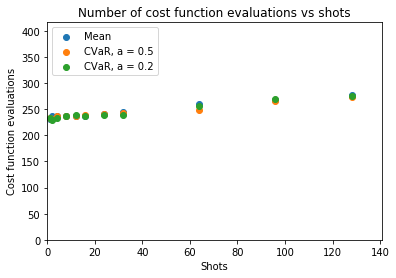

In [31]:
# Cost function evaluations vs shots
save_name = "figures/10qbits_comparison/nfev_vs_shots"

plot_comparison(x       = [df_plot_mean.shots, df_CVaR_plot_mean.shots, 
                           df_CVaR_02_plot_mean.shots],
                y       = [df_plot_mean.nfevs, df_CVaR_plot_mean.nfevs, 
                           df_CVaR_02_plot_mean.nfevs],
                legend  = ["Mean", "CVaR, a = 0.5", "CVaR, a = 0.2"],
                title   = "Number of cost function evaluations vs shots",
                xlabel  = "Shots",
                ylabel  = "Cost function evaluations",
                leg_loc = "upper left",
                save_as = save_name)

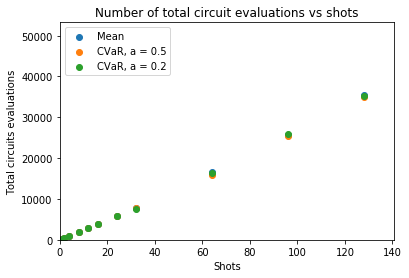

In [32]:
# Total circuit evaluations vs shots
save_name = "figures/10qbits_comparison/nfev_x_shots_vs_shots"

plot_comparison(x       = [df_plot_mean.shots, df_CVaR_plot_mean.shots, df_CVaR_02_plot_mean.shots],
                y       = [df_plot_mean.nfevs*df_plot_mean.shots, 
                           df_CVaR_plot_mean.nfevs*df_CVaR_plot_mean.shots,
                           df_CVaR_02_plot_mean.nfevs*df_CVaR_02_plot_mean.shots],
                legend  = ["Mean", "CVaR, a = 0.5", "CVaR, a = 0.2"],
                title   = "Number of total circuit evaluations vs shots",
                xlabel  = "Shots",
                ylabel  = "Total circuits evaluations",
                leg_loc = "upper left",
                save_as = save_name)

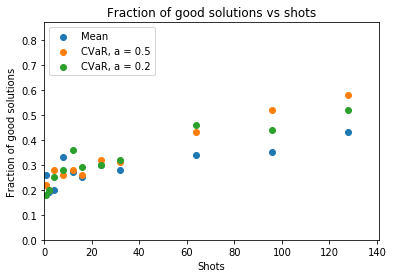

In [33]:
# Fraction of good solutions vs shots
save_name = "figures/10qbits_comparison/frac_vs_shots"

plot_comparison(x       = [df_plot_mean.shots, df_CVaR_plot_mean.shots, df_CVaR_02_plot_mean.shots],
                y       = [df_plot_mean.frac, df_CVaR_plot_mean.frac, df_CVaR_02_plot_mean.frac],
                legend  = ["Mean", "CVaR, a = 0.5", "CVaR, a = 0.2"],
                title   = "Fraction of good solutions vs shots",
                xlabel  = "Shots",
                ylabel  = "Fraction of good solutions",
                leg_loc = "upper left",
                save_as = save_name)

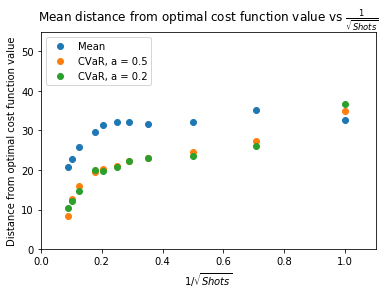

In [36]:
# Mean distance from optimal cost function value vs 1/sqrt(shots)
# (Brute cost is positive)
save_name = "figures/10qbits_comparison/dist_vs_inv_shots"

plot_comparison(x       = [1 / np.sqrt(df_plot_mean.shots), 
                           1 / np.sqrt(df_CVaR_plot_mean.shots), 
                           1 / np.sqrt(df_CVaR_02_plot_mean.shots)],
                y       = [brute_cost + df_plot_mean.cost, 
                           brute_cost + df_CVaR_plot_mean.cost, 
                           brute_cost + df_CVaR_02_plot_mean.cost],
                legend  = ["Mean", "CVaR, a = 0.5", "CVaR, a = 0.2"],
                title   = r"Mean distance from optimal cost function value vs $\frac{1}{\sqrt{Shots}}$",
                xlabel  = r"$1 / \sqrt{Shots}$",
                ylabel  = "Distance from optimal cost function value",
                leg_loc = "upper left",
                save_as = save_name)

### Chained optimization

#### Case cost function = mean expectation value

In [ ]:
# Variables declaration
WEIGHTS    = W2
N_QBITS    = n
DEPTH      = 2
SHOTS      = 8
BACKEND    = 'qasm_simulator'
FINAL_EVAL = 128
COST       = 'cost'

N_repetitions = 100
shots_list = [8, 16, 32, 64, 128]

In [ ]:
# A small scan, but we can get some results

for shot in shots_list:
    results_current = []
    output = 0
    # consider 8 shots file as the first iteration
    my_input = load_files("files/Scan_10qbits", [8])
    file_name  = "files/Scan_{0}qbits_{1}_and_{2}.pkl".format(n, SHOTS, shot)
    for rep in range(N_repetitions): 
        # for each optimization of 'my_input', take the results
        # and do a second optimization
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL,
                               COST,
                               theta = my_input[rep][5]) 
        
        if rep % 20 == 0:
            print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)

    save_object(results_current, file_name) 

In [ ]:
# Load original optimization files
original_opt = load_files("files/Scan_10qbits", shots_list)
df0, df00 = analyze_results(original_opt, shots_list, W2, brute_solution, 'cost')

# Load chained optimization files
chained_opt = load_files("files/Scan_10qbits_8_and", shots_list)
df1, df3 = analyze_results(chained_opt, shots_list, W2, brute_solution, 'cost')

In [ ]:
# Compute total number of circuit evaluations
df1['total_circ_eval'] = df1['ncircevs'] + \
    pd.concat([df0[df0['shots'] == 8]]*5).reset_index(level=0)['ncircevs']

# Group by shots and average
df2 = df1.groupby(['shots']).mean()
df2.reset_index(level=0, inplace=True)

# Add fraction of valid solutions to the data frame used for plotting
df2['frac'] = df3['frac']

In [ ]:
# Number of total circuit evaluations vs shots
plot_comparison(x       = [df00["shots"], df2["shots"]], 
                y       = [df00["ncircevs"], df2["ncircevs"]],
                legend  = ["orignal opt", "chianed opt"],
                title   = "Number of total circuit evaluations vs shots",
                xlabel  = "Shots",
                ylabel  = "Total circuits evaluations",
                leg_loc = "upper left",
                save_as = "figures/nfev_x_shots_vs_shots_avg100_qbit10_comparison_chain")

In [ ]:
# Fraction of good solutions vs shots
plot_comparison(x       = [df00["shots"], df2["shots"]], 
                y       = [df00["frac"], df2["frac"]],
                legend  = ["orignal opt", "chained opt"],
                title   = "Fraction of good solutions vs shots",
                xlabel  = "Shots",
                ylabel  = "Fraction of good solutions",
                leg_loc = "upper left",
                save_as = "figures/frac_vs_shots_avg100_qbit10_comparison_chain")

#### Case cost function = CVaR($\alpha = 0.5$)

In [ ]:
# Variables declaration
WEIGHTS    = W2
N_QBITS    = n
DEPTH      = 2
SHOTS      = 8
BACKEND    = 'qasm_simulator'
FINAL_EVAL = 128
COST       = 'cvar'
ALPHA      = 0.5

N_repetitions = 100
shots_list = [8, 16, 32, 64, 128]

In [ ]:
# A small scan, but we can get some results

for shot in shots_list:
    results_current = []
    output = 0
    # consider 8 shots file as the first iteration
    my_input = load_files("files/Scan_CVaR_10qbits", [8])
    file_name  = "files/Scan_CVaR_{0}qbits_{1}_and_{2}.pkl".format(n, SHOTS, shot)
    for rep in range(N_repetitions): 
        # for each optimization of 'my_input', take the results
        # and do a second optimization
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL,
                               COST,
                               ALPHA,
                               theta = my_input[rep][5]) 
        
        if rep % 20 == 0:
            print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)

    save_object(results_current, file_name)

In [ ]:
# Load original optimization files
original_opt_cvar = load_files("files/Scan_CVaR_10qbits", shots_list)
df0_cvar, df00_cvar = analyze_results(original_opt_cvar, shots_list, W2, brute_solution, 'cvar', 0.5)

# Load chained optimization files
chained_opt_cvar = load_files("files/Scan_CVaR_10qbits_8_and", shots_list)
df1_cvar, df3_cvar = analyze_results(chained_opt_cvar, shots_list, W2, brute_solution, 'cvar', 0.5)

In [ ]:
# Compute total number of circuit evaluations
df1_cvar['total_cric_eval'] = df1_cvar['ncircevs'] + \
    pd.concat([df0_cvar[df0_cvar['shots'] == 8]]*5).reset_index(level=0)['ncircevs']

# Group by shots and average
df2_cvar = df1_cvar.groupby(['shots']).mean()
df2_cvar.reset_index(level=0, inplace=True)

# Add fraction of valid solutions to the data frame used for plotting
df2_cvar['frac'] = df3_cvar['frac']

In [ ]:
# NUmber of total circuit evaluations vs shots
plot_comparison(x       = [df00_cvar["shots"], df2_cvar["shots"]], 
                y       = [df00_cvar["ncircevs"], df2_cvar["ncircevs"]],
                legend  = ["orignal opt", "chianed opt"],
                title   = "Number of total circuit evaluations vs shots",
                xlabel  = "Shots",
                ylabel  = "Total circuits evaluations",
                leg_loc = "upper left",
                save_as = "figures/nfev_x_shots_vs_shots_avg100_qbit10_comparison_chain_cvar05")

In [ ]:
# Fractions of good solutions vs shots
plot_comparison(x       = [df00_cvar["shots"], df2_cvar["shots"]], 
                y       = [df00_cvar["frac"], df2_cvar["frac"]],
                legend  = ["orignal opt", "chained opt"],
                title   = "Fraction of good solutions vs shots",
                xlabel  = "Shots",
                ylabel  = "Fraction of good solutions",
                leg_loc = "upper left",
                save_as = "figures/frac_vs_shots_avg100_qbit10_comparison_chain_cvar05")

#### Case cost function = CVaR($\alpha = 0.2$)

In [ ]:
# Variables declaration
WEIGHTS    = W2
N_QBITS    = n
DEPTH      = 2
SHOTS      = 8
BACKEND    = 'qasm_simulator'
FINAL_EVAL = 128
COST       = 'cvar'
ALPHA      = 0.2

N_repetitions = 100
shots_list = [8, 16, 32, 64, 128]

In [ ]:
# A small scan, but we can get some results

for shot in shots_list:
    results_current = []
    output = 0
    # consider 8 shots file as the first iteration
    my_input = load_files("files/Scan_CVaR_02_10qbits", [8])
    file_name  = "files/Scan_CVaR_02_{0}qbits_{1}_and_{2}.pkl".format(n, SHOTS, shot)
    for rep in range(N_repetitions): 
        # for each optimization of 'my_input', take the results
        # and do a second optimization
        output = time_vs_shots(shot,
                               WEIGHTS,
                               N_QBITS,
                               DEPTH,
                               BACKEND,
                               FINAL_EVAL,
                               COST,
                               ALPHA,
                               theta = my_input[rep][5]) 
        
        if rep % 20 == 0:
            print("Done with", str(shot), "shots, repetition", rep)
        results_current.append(output)

    save_object(results_current, file_name)

In [ ]:
# Load original optimization files
original_opt_cvar_02 = load_files("files/Scan_CVaR_02_10qbits", shots_list)
df0_cvar_02, df00_cvar_02 = analyze_results(original_opt_cvar_02, shots_list, W2, brute_solution, 'cvar', 0.2)

# Load chained optimization files
chained_opt_cvar_02 = load_files("files/Scan_CVaR_02_10qbits_8_and", shots_list)
df1_cvar_02, df3_cvar_02 = analyze_results(chained_opt_cvar_02, shots_list, W2, brute_solution, 'cvar', 0.2)

In [ ]:
# Compute total number of circuit evaluations
df1_cvar_02['total_cric_eval'] = df1_cvar_02['ncircevs'] + \
    pd.concat([df0_cvar_02[df0_cvar_02['shots'] == 8]]*5).reset_index(level=0)['ncircevs']

# Group by shots and average
df2_cvar_02 = df1_cvar_02.groupby(['shots']).mean()
df2_cvar_02.reset_index(level=0, inplace=True)

# Add fraction of valid solutions to the data frame used for plotting
df2_cvar_02['frac'] = df3_cvar_02['frac']

In [ ]:
# Number of total circuit evaluations vs shots
plot_comparison(x       = [df00_cvar_02["shots"], df2_cvar_02["shots"]], 
                y       = [df00_cvar_02["ncircevs"], df2_cvar_02["ncircevs"]],
                legend  = ["orignal opt", "chianed opt"],
                title   = "Number of total circuit evaluations vs shots",
                xlabel  = "Shots",
                ylabel  = "Total circuits evaluations",
                leg_loc = "upper left",
                save_as = "figures/nfev_x_shots_vs_shots_avg100_qbit10_comparison_chain_cvar02")

In [ ]:
# Fraction of good solutions vs shots
plot_comparison(x       = [df00_cvar_02["shots"], df2_cvar_02["shots"]], 
                y       = [df00_cvar_02["frac"], df2_cvar_02["frac"]],
                legend  = ["orignal opt", "chained opt"],
                title   = "Fraction of good solutions vs shots",
                xlabel  = "Shots",
                ylabel  = "Fraction of good solutions",
                leg_loc = "upper left",
                save_as = "figures/frac_vs_shots_avg100_qbit10_comparison_chain_cvar02")